In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# define training and test data directories
data_dir = 'data/'

# define dataloader parameters
batch_size = 32
num_workers = 4

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
                  for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print (class_names)
print('Num training images: ', len(image_datasets['train']))
print('Num val images: ', len(image_datasets['val']))
print('Num test images: ', len(image_datasets['test']))

['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
Num training images:  3072
Num val images:  384
Num test images:  992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

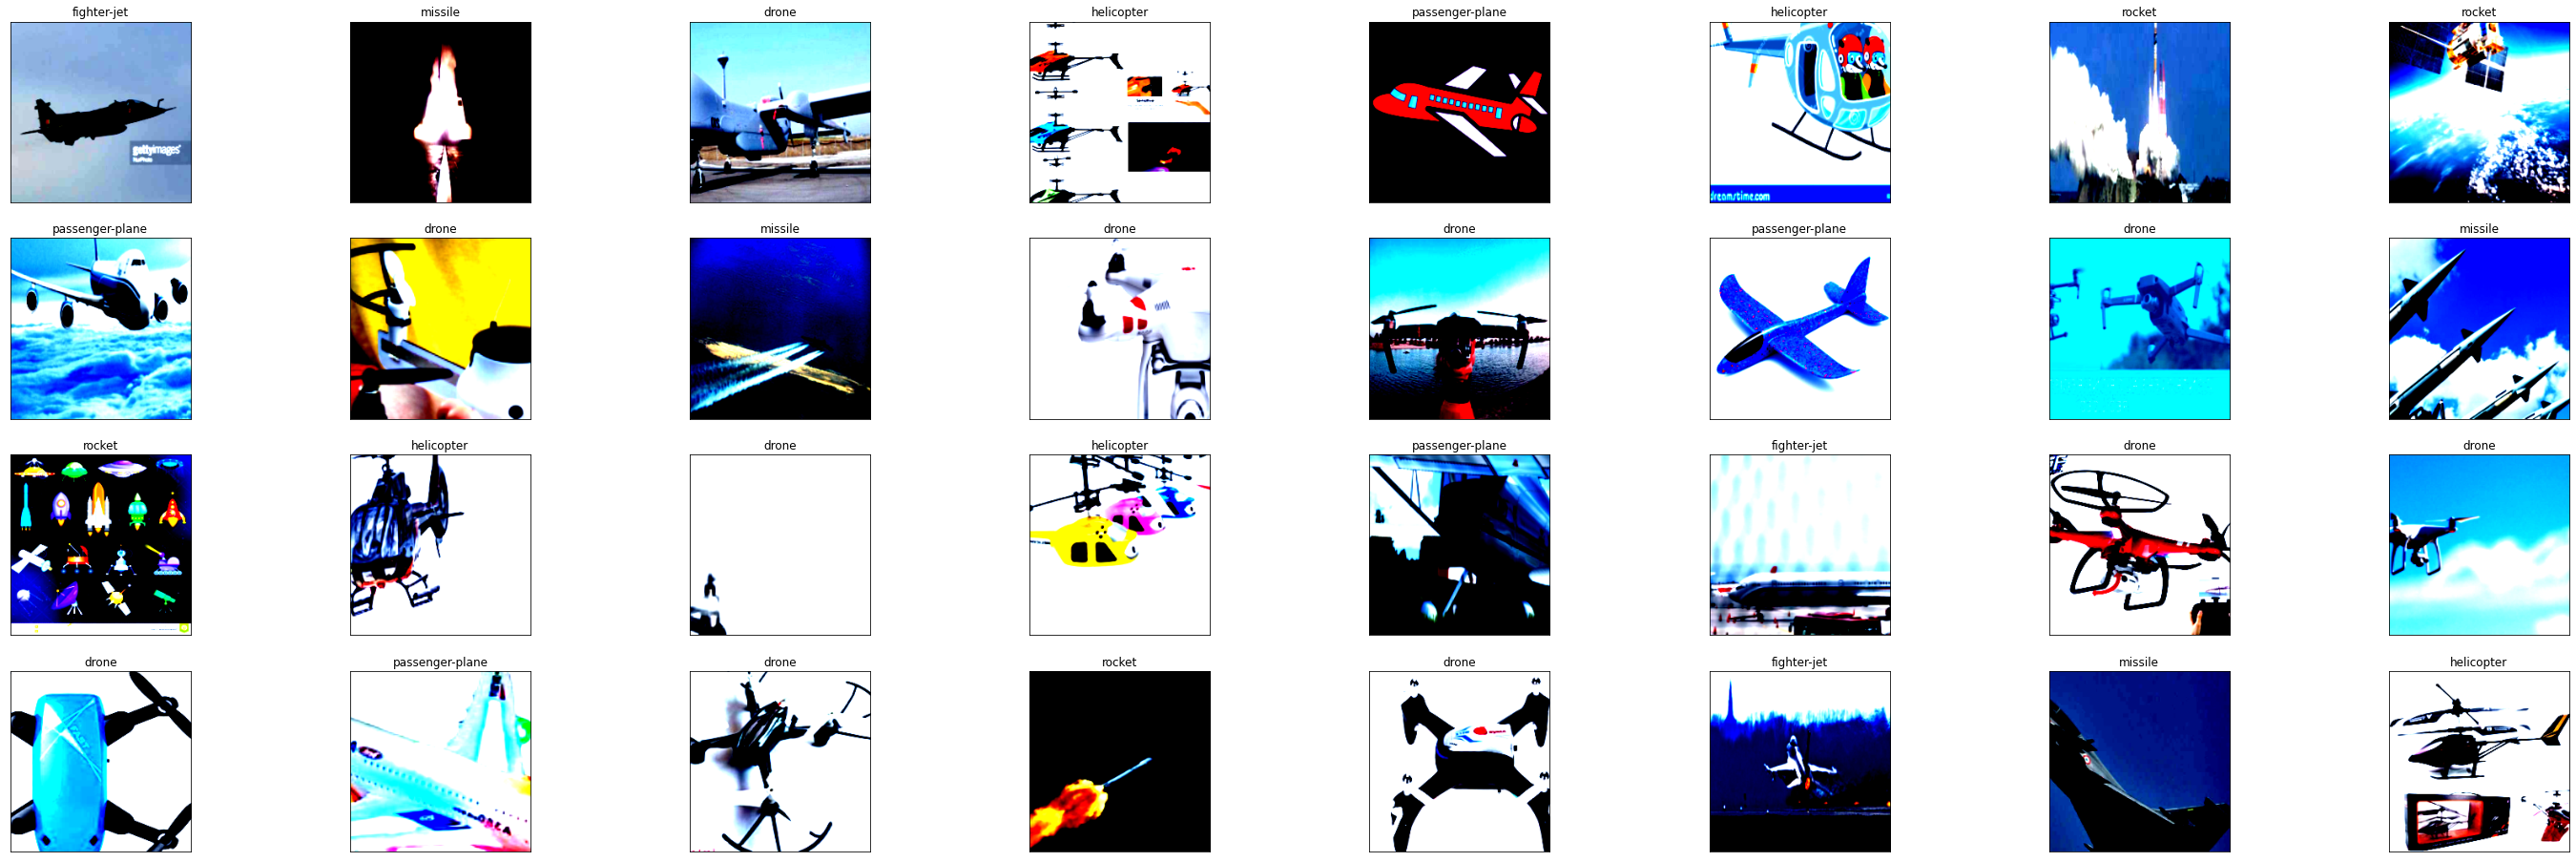

In [4]:
# Visualize some sample data
# obtain one batch of training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50, 16))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(class_names[labels[idx]])

In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn(pretrained=True)

# print out the model structure
# print(vgg16)
# print(vgg16.classifier[6].in_features) 
# print(vgg16.classifier[6].out_features)

# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [6]:
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features
n_interm_outputs = 1000

fc2_layer = nn.Linear(n_inputs, n_interm_outputs)
fc3_layer = nn.Linear(n_interm_outputs, len(class_names))

vgg16.classifier[5] = fc2_layer
vgg16.classifier[6] = fc3_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# print(vgg16.classifier[6].out_features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [8]:
# number of epochs to train the model
n_epochs = 32
valid_loss_min = np.Inf # track change in validation loss

class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))
n_batch = 0
conf_matrix = 0

train_acc = list()
val_acc = list()
test_acc = list()

for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    test_loss = 0.0

    conf_matrix = np.zeros((len(class_names), len(class_names)))
    
    ###################
    # train the model #
    ###################
    vgg16.train()
    batch_i = 0
    for data, target in dataloaders['train']:
        batch_i += 1
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        #print('Epoch %d, Batch %d' %(epoch, batch_i))

    # Switch VGG16 model to evaluation mode:
    vgg16.eval()

    ######################    
    # validate the model #
    ######################
    for data, target in dataloaders['val']:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    ##################
    # test the model #
    ##################
    for data, target in dataloaders['test']:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss 
        test_loss += loss.item()*data.size(0)

        # convert output probabilities to predicted class
        probability, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            conf_matrix[pred[i]][label] += 1
    
    # calculate average losses
    train_loss = train_loss/len(dataloaders['train'].sampler)
    valid_loss = valid_loss/len(dataloaders['val'].sampler)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # calculate avg test loss
    test_loss = test_loss/len(dataloaders['test'].dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
        
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), 'iitm_arihant_vgg16.pt')
        valid_loss_min = valid_loss

    for i in range(6):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                class_names[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

    train_acc.append(train_loss)
    val_acc.append(valid_loss)
    test_acc.append(test_loss)
    
    print(conf_matrix)

Epoch: 1 	Training Loss: 1.703293 	Validation Loss: 1.609009
Test Loss: 1.648865

Validation loss decreased (inf --> 1.609009).  Saving model ...
Test Accuracy of drone: 22% (43/192)
Test Accuracy of fighter-jet: 51% (90/176)
Test Accuracy of helicopter: 69% (127/184)
Test Accuracy of missile: 25% (49/191)
Test Accuracy of passenger-plane: 53% (100/188)
Test Accuracy of rocket: 67% (41/61)

Test Accuracy (Overall): 45% (450/992)
[[ 43.  14.  11.   6.   5.   0.]
 [ 66.  90.  19.  31.  63.   4.]
 [ 31.  26. 127.   9.   6.   4.]
 [ 23.  16.  13.  49.   8.   5.]
 [ 20.  28.  11.  15. 100.   7.]
 [  9.   2.   3.  81.   6.  41.]]
Epoch: 2 	Training Loss: 1.537596 	Validation Loss: 1.468440
Test Loss: 1.544623

Validation loss decreased (1.609009 --> 1.468440).  Saving model ...
Test Accuracy of drone: 22% (85/384)
Test Accuracy of fighter-jet: 53% (187/352)
Test Accuracy of helicopter: 72% (268/368)
Test Accuracy of missile: 23% (90/382)
Test Accuracy of passenger-plane: 53% (202/376)
Test A

Epoch: 14 	Training Loss: 0.874013 	Validation Loss: 1.009032
Test Loss: 1.226513

Validation loss decreased (1.010290 --> 1.009032).  Saving model ...
Test Accuracy of drone: 22% (616/2688)
Test Accuracy of fighter-jet: 59% (1476/2464)
Test Accuracy of helicopter: 79% (2044/2576)
Test Accuracy of missile: 37% (997/2674)
Test Accuracy of passenger-plane: 53% (1420/2632)
Test Accuracy of rocket: 76% (657/854)

Test Accuracy (Overall): 51% (7210/13888)
[[ 44.   8.   3.   2.   1.   1.]
 [ 63. 104.  11.  20.  54.   1.]
 [ 37.  17. 154.   4.   9.   5.]
 [ 18.  15.   6.  98.  14.   1.]
 [ 23.  30.   8.  11. 105.   5.]
 [  7.   2.   2.  56.   5.  48.]]
Epoch: 15 	Training Loss: 0.855354 	Validation Loss: 1.010328
Test Loss: 1.217960

Test Accuracy of drone: 22% (662/2880)
Test Accuracy of fighter-jet: 59% (1580/2640)
Test Accuracy of helicopter: 79% (2198/2760)
Test Accuracy of missile: 38% (1100/2865)
Test Accuracy of passenger-plane: 54% (1525/2820)
Test Accuracy of rocket: 76% (704/915)

T

Epoch: 28 	Training Loss: 0.753437 	Validation Loss: 1.004031
Test Loss: 1.245555

Test Accuracy of drone: 23% (1283/5376)
Test Accuracy of fighter-jet: 58% (2897/4928)
Test Accuracy of helicopter: 81% (4198/5152)
Test Accuracy of missile: 46% (2467/5348)
Test Accuracy of passenger-plane: 55% (2923/5264)
Test Accuracy of rocket: 78% (1341/1708)

Test Accuracy (Overall): 54% (15109/27776)
[[ 45.   6.   5.   4.   1.   1.]
 [ 63. 103.   8.  15.  52.   2.]
 [ 30.  17. 154.   1.   8.   4.]
 [ 19.  13.   7. 104.  13.   1.]
 [ 29.  35.   8.  13. 110.   4.]
 [  6.   2.   2.  54.   4.  49.]]
Epoch: 29 	Training Loss: 0.754326 	Validation Loss: 0.994996
Test Loss: 1.239520

Test Accuracy of drone: 23% (1327/5568)
Test Accuracy of fighter-jet: 58% (2996/5104)
Test Accuracy of helicopter: 81% (4351/5336)
Test Accuracy of missile: 46% (2576/5539)
Test Accuracy of passenger-plane: 55% (3033/5452)
Test Accuracy of rocket: 78% (1391/1769)

Test Accuracy (Overall): 54% (15674/28768)
[[ 44.   6.   6.   

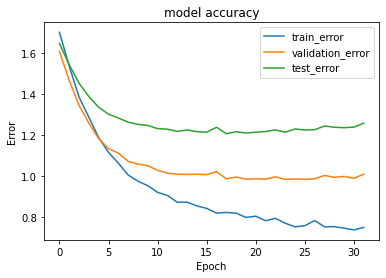

In [9]:
# plotting train/valid/test loss with epochs
plt.title('model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Error')

plt.plot(train_acc)
plt.plot(val_acc)
plt.plot(test_acc)

ax = plt.gca()
ax.legend(['train_error', 'validation_error', 'test_error'])

plt.show()

[[ 47.   6.   8.   3.   2.   1.]
 [ 54. 100.   9.  13.  49.   1.]
 [ 23.  15. 150.   0.   6.   2.]
 [ 28.  15.   7. 108.  14.   1.]
 [ 34.  38.   8.  13. 112.   4.]
 [  6.   2.   2.  54.   5.  52.]]


Text(0.5, 1.0, 'Confusion Matrix')

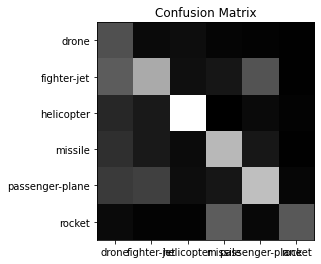

In [10]:
# plot the final confusion matrix
print(conf_matrix)
plt.imshow(conf_matrix, cmap='gray')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.title('Confusion Matrix')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

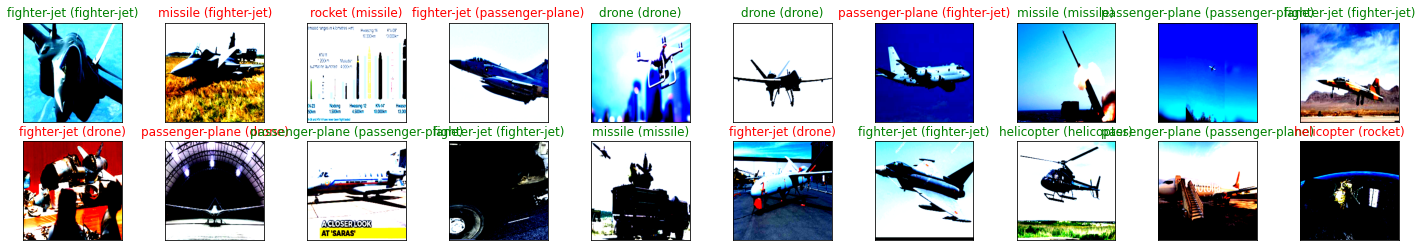

In [11]:
# obtain one batch of test images
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images_cuda = images.cuda()

# get sample outputs
output = vgg16(images_cuda)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))